In [4]:
# Pytorch Lightning Utils
import pytorch_lightning as pl
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger

# Pytorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.optimizer import Optimizer, required 
import timm


# ML Utils
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
import cv2
import numpy as np
import pandas as pd
from PIL import Image

# Visualization Utils
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"

import seaborn as sns

from colorama import Fore, Back, Style
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
c_ = Fore.CYAN
y_ = Fore.YELLOW
res = Style.RESET_ALL

# Image Augmentation Library
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Misc Utils
import os
import random
from pathlib import Path

# Hide Warning
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [5]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

INPUT = Path('../data/')
TRAIN_IMG_DIR = INPUT /'train'            
TEST_IMG_DIR = INPUT /'test'

train.shape, test.shape

((9912, 14), (8, 13))

In [32]:
def get_train_path(image_id):
    return "./data/train/{}.jpg".format(image_id)

def get_test_path(image_id):
    return "./data/test/{}.jpg".format(image_id)

train['file_path'] = train['Id'].apply(get_train_path)
test['file_path'] = test['Id'].apply(get_test_path)

In [7]:
#print(f"{r_}TRAINING DATA{res}")
train.head().style.set_properties(**{'background-color': 'lightyellow',
                           'color': 'brown'})

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,file_path
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../data/train/0007de18844b0dbbb5e1f607da0606e0.jpg
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../data/train/0009c66b9439883ba2750fb825e1d7db.jpg
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../data/train/0013fd999caf9a3efe1352ca1b0d937e.jpg
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../data/train/0018df346ac9c1d8413cfcc888ca8246.jpg
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../data/train/001dc955e10590d3ca4673f034feeef2.jpg


# Visualizing the target variable

In [8]:
# create the bins
import plotly.express as px

In [9]:
counts, bins = np.histogram(train['Pawpularity'], bins= range(0, 110, 10))
bins = 0.5* (bins[:-1] + bins[1:])

fig = px.bar(x = bins, y=counts)
#fig = px.histogram(train['Pawpularity'])

fig.update_layout(title_text='Pawpularity distribution', 
                  xaxis=dict(title='Pawpularity'),
                  yaxis=dict(title='Count'),
                  showlegend=False
                 )
fig.show()

In [10]:
Config = {
    'seed' : 2021,  # setting the seed
    'debug': False,  # debug mode
    'num_folds': 5, # number of folds to split
    'trn_folds': [0, ],  # folds to train
    'batch_size': 12,  # batch size
    'num_workers' : 0,  # number of cpu workers
    'img_size': 512,  # image size
    'model': 'efficientnet_b3',  # model to use
    'img_ftr_len': 500, # length of vector to encode the images in
    'epochs': 15,        # numbers of epochs
    'precision': 16,
    'weight_decay': 1e-6,
    
    # learning
    'lr': 1e-3,
    'T_max': 10,
    'min_lr': 1e-6,
    'patience_earlystop': 3,
}   


def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(Config['seed'])

# Creating folds

We create Stratified Kfolds of the data. We first bin values into discrete intervals with **pd.cut** and then split

In [11]:

def create_folds(data, num_splits, seed):
    data['kfold'] = -1
    
    # an intelligent guess on number of bins. which is log(data)
    num_bins = int(np.floor(1 + np.log2(len(data))))
    data.loc[:,'bins'] = pd.cut(data['Pawpularity'], bins=num_bins, labels=False)
    
    kf = model_selection.StratifiedKFold(n_splits = num_splits, shuffle=True, random_state=seed)
    
    for f, (t_,v_) in enumerate(kf.split(X=data, y = data.bins.values)):
        data.loc[v_, 'kfold'] = f
        
    data = data.drop('bins', axis=1)
    
    return data

train = create_folds(train, Config['num_folds'], Config['seed'])

In [33]:

train.to_csv('../data/train_processed.csv',index=False)
test.to_csv('../data/test_processed.csv',index=False)

# Dataset Class

In [12]:

class PetPawularityDS(Dataset):
    def __init__(self, df, split='train', transform=None):
        self.df = df
        self.transforms = transform
        
        self.ftrcols = [col for col in df.columns if col not in ['Id','Pawpularity','file_path','kfold']]
        self.split = split
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'file_path']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ftrs = torch.Tensor(np.array(self.df.loc[idx, self.ftrcols].values).astype(np.float32))
        
        if self.split == 'train':
            score = torch.Tensor([self.df.loc[idx, 'Pawpularity']])
            
        if self.transforms:
            img = self.transforms(image = img)['image']
            
        if self.split == 'train':
            return img, ftrs, score
        else:
            img, ftrs

# Augmentations

In [13]:
def get_train_transforms():
    return A.Compose([
                        A.Resize(Config['img_size'], Config['img_size']),
                        A.HorizontalFlip(p=0.5),
                        A.Normalize(
                                mean=[0.485, 0.456, 0.406], 
                                std=[0.229, 0.224, 0.225], 
                            ),
                        ToTensorV2()
                    ])


def get_valid_transforms():
    return A.Compose([
                        A.Resize(Config['img_size'], Config['img_size']),
                        A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                        ToTensorV2(),
                ])

def get_test_transforms():
    return A.Compose([
                    A.Resize(Config['img_size'], Config['img_size']),
                    A.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                        ),
                    ToTensorV2(),
                ])

In [14]:
# Pytorch Lightning DataModule

def train_collate_fn(data):
    images = torch.zeros((len(data),3 , Config['img_size'], Config['img_size']))
    datafeatures= torch.zeros((len(data)), 12)
    
    scores = torch.zeros((len(data), 1))
    
    for i in range(len(data)):
        images[i,...] = data[i][0]
        datafeatures[i,...] = data[i][1]
        scores[i, ...] = data[i][2]
        
    return images.float(), datafeatures.float(), scores.float()

def test_collate_fn(data):
    
    images = torch.zeros((len(data), 3, Config['img_size'], Config['img_size']))
    datafeatures = torch.zeros((len(data), 12))
    
    for i in range(len(data)):
        images[i, ...] = data[i][0]
        datafeatures[i, ...] = data[i][1]
        
    return images.float(), datafeatures.float()


In [15]:
class PawpularityDModule(pl.LightningDataModule):
    def __init__(self, df, fld):
        super().__init__()
        self.fold = fld
        self.train_data = df[df['kfold'] != self.fold].reset_index(drop=True)
        self.val_data = df[df['kfold'] != self.fold].reset_index(drop=True)
        self.test_data = test
        
    def setup(self, stage=None):
        self.train_dataset = PetPawularityDS(
            df = self.train_data,
            transform = get_train_transforms()
        )
        
        self.val_dataset = PetPawularityDS(
            df = self.val_data,
            transform = get_valid_transforms()
        )
        
        self.test_dataset = PetPawularityDS(
            df = self.test_data,
            transform = get_test_transforms(),
            split='test'
        )
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = Config['batch_size'],
            shuffle=True,
            num_workers = Config['num_workers'],
            pin_memory=True,
            collate_fn= train_collate_fn
        )
        
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size = Config['batch_size'],
            shuffle=False,
            num_workers = Config['num_workers'],
            pin_memory = True,
            collate_fn = train_collate_fn
        )
        
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset, 
            batch_size = Config['batch_size'],
            shuffle=False, 
            num_workers = Config['num_workers'],
            pin_memory=True,
            collate_fn = test_collate_fn
        )

# Training data visualization

 tensor([[31., 22., 13., 89.],
        [30., 33., 43., 44.],
        [28., 82., 46., 24.]]) 




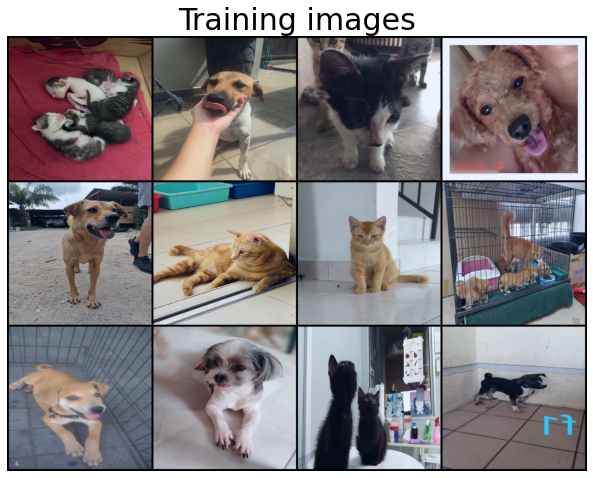

In [16]:

dm = PawpularityDModule(train, 0)
dm.setup()

# plot some training images
import torchvision.utils as vutils
img, ftrs, targets = next(iter(dm.train_dataloader()))

plt.figure(figsize=(16, 8))
plt.axis('off')
plt.title('Training images', fontsize=30)

_ = plt.imshow(vutils.make_grid(
    img[:12], nrow=4, padding=7, normalize=True
).cpu().numpy().transpose((1, 2, 0)))

print(f"{g_} {targets[:12].reshape((3,4))} {res}\n\n")

# Pytorch Lightning Module

In [27]:
class Trainer(pl.LightningModule):
    def __init__(self, model_name = Config['model'], out_features = Config['img_ftr_len'],
                 pretrained = True):
        super().__init__()
        
        # feature extractor
        self.model = timm.create_model(model_name, pretrained=pretrained,
                                       num_classes = out_features)
        
        # final fc layer
        self.finalfc = nn.Sequential(
            nn.Linear(out_features + 12, 120),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(120, 1)
        )
        
        self.criterion = nn.MSELoss()
        
    def forward(self, img, ftrs):
        # featur extractor extracts features from the image
        imgouts = self.model(img)
        
        # we combine the meta featurse with the image features given
        ftrout = torch.cat([imgouts, ftrs], dim= -1)
        
        # we the npass the combined feature into final Layer
        output = self.finalfc(ftrout)
        
        return output
    
    def training_step(self ,batch, batch_idx):
        img, ftrs, score = batch
        
        output = self.forward(img, ftrs)
        
        loss = self.criterion(output, score)
        
        try:
            rmse = mean_squared_error(score.detach().cpu(), output.detach().cpu(), squared=False)
            
            self.log("RMSE", rmse, on_step = True, prog_bar = True, logger=True)
            self.log("Train Loss", loss, on_step = True, prog_bar = True, logger=True)
            
        except:
            pass
        
        return {'loss': loss, 'predictions': output.detach(), 'labels': score.detach()}
    
    def training_epoch_end(self, outputs):
        preds = []
        labels = []
        
        for output in outputs:
            
            preds.append(output['predictions'])
            labels.append(output['labels'])
            
        labels = torch.stack(labels)
        preds = torch.stack(preds)
        
        
        train_rmse = mean_squared_error(labels.detach().cpu(), preds.detach().cpu(), squared=False)
        
        self.print(f'Epoch {self.current_epoch}: Training RMSE: {train_rmse:.4f}')
        self.log('mean_train_rmse', train_rmse, prog_bar=False, logger=True)
        

    def validation_epoch_end(self, outputs):
    
        preds = []
        labels = []
        
        for output in outputs:
            preds += output['predictions']
            labels += output['labels']

        labels = torch.stack(labels)
        preds = torch.stack(preds)

        val_rmse = mean_squared_error(labels.detach().cpu(), preds.detach().cpu(), squared=False)
        
        self.print(f'Epoch {self.current_epoch}: Validation RMSE: {val_rmse:.4f}')

        
        self.log("val_rmse", val_rmse, prog_bar=True, logger=True)
        

    def test_step(self, batch, batch_idx):
        img, ftrs = batch
        output = self.forward(img, ftrs)
        
        return output   

    def configure_optimizers(self):

        param_optimizer = list(self.model.named_parameters())
        
        # configuring parameters
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": Config['weight_decay'],
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]

        # we use adam optimizer with Cosine annealing LR
        optimizer = Adam(optimizer_parameters, lr=Config['lr'])
        
        
        scheduler = CosineAnnealingLR(optimizer,
                                T_max=Config['T_max'],
                                eta_min=Config['min_lr'],
                                last_epoch=-1)

        return dict(
            optimizer=optimizer,
            lr_scheduler=scheduler
        )


In [29]:
model = Trainer()
training_metrics = []

for fold in Config['trn_folds']:
    print(f"{'='*38} Fold: {fold} {'='*38}")
    
    # create data module
    data_module = PawpularityDModule(train, fold)
    
    # stop the training early
    early_stopping_callback = EarlyStopping(monitor='RMSE', mode='min', patience=Config['patience_earlystop'])
    
    
    # store model checkpoints
    checkpoint_callback = ModelCheckpoint(
        dirpath='checkpoints',
        filename='best-checkpoint-{fold}-{val_rmse:.3f}',
        save_top_k = Config['epochs'],
        verbose=True,
        monitor='val_rmse',
        mode='min'
    )
    
    # define trainer
    trainer = pl.Trainer(
        gpus=2,
        accelerator='dp',
        checkpoint_callback=True,
        callbacks=[early_stopping_callback, checkpoint_callback],
        max_epochs= Config['epochs'],
        precision=Config['precision'],
        progress_bar_refresh_rate=1,
        num_sanity_val_steps=1 if Config['debug'] else 0,
        stochastic_weight_avg = True,
    )
    
    # fit
    trainer.fit(model, data_module)

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


====================================== Fold: 0 ======================================



  | Name      | Type         | Params
-------------------------------------------
0 | model     | EfficientNet | 11.5 M
1 | finalfc   | Sequential   | 61.7 K
2 | criterion | MSELoss      | 0     
-------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.106    Total estimated model params size (MB)


Epoch 0: Training RMSE: 8.9085
Epoch 0: 100%|██████████| 661/661 [38:30<00:00,  3.49s/it, loss=369, v_num=3, RMSE=17.40, Train Loss=304.0]

Epoch 0, global step 660: val_rmse was not in top 15


Epoch 1: Training RMSE: 6.6448
Epoch 0: 100%|██████████| 661/661 [43:20<00:00,  3.93s/it, loss=369, v_num=3, RMSE=17.40, Train Loss=304.0]

Epoch 1, global step 1321: val_rmse was not in top 15


Epoch 2: Training RMSE: 6.4426
Epoch 0: 100%|██████████| 661/661 [48:10<00:00,  4.37s/it, loss=369, v_num=3, RMSE=17.40, Train Loss=304.0]

Epoch 2, global step 1982: val_rmse was not in top 15


Epoch 3: Training RMSE: 6.2637
Epoch 0: 100%|██████████| 661/661 [53:02<00:00,  4.81s/it, loss=369, v_num=3, RMSE=17.40, Train Loss=304.0]

Epoch 3, global step 2643: val_rmse was not in top 15


Epoch 3: 100%|██████████| 661/661 [04:51<00:00,  2.27it/s, loss=332, v_num=5, RMSE=15.80, Train Loss=248.0]
